# **Feature Selection with Hierarchical Clustering**

## **Librerías**

In [2]:
import pandas as pd
import numpy as np

In [3]:
pd.options.display.max_columns = False

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
from sklearn.preprocessing import StandardScaler

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

## **Datos**

In [6]:
credit_score = pd.read_csv('../../Data/Raw/credit_score.csv')
credit_score.shape

(1000, 87)

In [7]:
credit_score.sample()

,CUST_ID,INCOME,SAVINGS,DEBT,R_SAVINGS_INCOME,R_DEBT_INCOME,R_DEBT_SAVINGS,T_CLOTHING_12,T_CLOTHING_6,R_CLOTHING,R_CLOTHING_INCOME,R_CLOTHING_SAVINGS,R_CLOTHING_DEBT,T_EDUCATION_12,T_EDUCATION_6,R_EDUCATION,R_EDUCATION_INCOME,R_EDUCATION_SAVINGS,R_EDUCATION_DEBT,T_ENTERTAINMENT_12,T_ENTERTAINMENT_6,R_ENTERTAINMENT,R_ENTERTAINMENT_INCOME,R_ENTERTAINMENT_SAVINGS,R_ENTERTAINMENT_DEBT,T_FINES_12,T_FINES_6,R_FINES,R_FINES_INCOME,R_FINES_SAVINGS,R_FINES_DEBT,T_GAMBLING_12,T_GAMBLING_6,R_GAMBLING,R_GAMBLING_INCOME,R_GAMBLING_SAVINGS,R_GAMBLING_DEBT,T_GROCERIES_12,T_GROCERIES_6,R_GROCERIES,...,R_HEALTH_SAVINGS,R_HEALTH_DEBT,T_HOUSING_12,T_HOUSING_6,R_HOUSING,R_HOUSING_INCOME,R_HOUSING_SAVINGS,R_HOUSING_DEBT,T_TAX_12,T_TAX_6,R_TAX,R_TAX_INCOME,R_TAX_SAVINGS,R_TAX_DEBT,T_TRAVEL_12,T_TRAVEL_6,R_TRAVEL,R_TRAVEL_INCOME,R_TRAVEL_SAVINGS,R_TRAVEL_DEBT,T_UTILITIES_12,T_UTILITIES_6,R_UTILITIES,R_UTILITIES_INCOME,R_UTILITIES_SAVINGS,R_UTILITIES_DEBT,T_EXPENDITURE_12,T_EXPENDITURE_6,R_EXPENDITURE,R_EXPENDITURE_INCOME,R_EXPENDITURE_SAVINGS,R_EXPENDITURE_DEBT,CAT_GAMBLING,CAT_DEBT,CAT_CREDIT_CARD,CAT_MORTGAGE,CAT_SAVINGS_ACCOUNT,CAT_DEPENDENTS,CREDIT_SCORE,DEFAULT
939,CYBLLYCZ1O,339872,962972,2747302,2.8333,8.0833,2.8529,25286,15775,0.6239,0.0744,0.0263,0.0092,9198,4611,0.5013,0.0271,0.0096,0.0033,45137,28369,0.6285,0.1328,0.0469,0.0164,0,0,0.5617,0.0,0.0,0.0,0,0,0.5594,0.0,0.0,0.0,37956,19569,0.5156,...,0.0167,0.0059,0,0,0.5062,0.0,0.0,0.0,13954,7620,0.5461,0.0411,0.0145,0.0051,117286,62303,0.5312,0.3451,0.1218,0.0427,18327,9212,0.5026,0.0539,0.019,0.0067,283227,154682,0.5461,0.8333,0.2941,0.1031,No,1,1,0,1,0,558,1


In [11]:
credit_score.describe()

,INCOME,SAVINGS,DEBT,R_SAVINGS_INCOME,R_DEBT_INCOME,R_DEBT_SAVINGS,T_CLOTHING_12,T_CLOTHING_6,R_CLOTHING,R_CLOTHING_INCOME,R_CLOTHING_SAVINGS,R_CLOTHING_DEBT,T_EDUCATION_12,T_EDUCATION_6,R_EDUCATION,R_EDUCATION_INCOME,R_EDUCATION_SAVINGS,R_EDUCATION_DEBT,T_ENTERTAINMENT_12,T_ENTERTAINMENT_6,R_ENTERTAINMENT,R_ENTERTAINMENT_INCOME,R_ENTERTAINMENT_SAVINGS,R_ENTERTAINMENT_DEBT,T_FINES_12,T_FINES_6,R_FINES,R_FINES_INCOME,R_FINES_SAVINGS,R_FINES_DEBT,T_GAMBLING_12,T_GAMBLING_6,R_GAMBLING,R_GAMBLING_INCOME,R_GAMBLING_SAVINGS,R_GAMBLING_DEBT,T_GROCERIES_12,T_GROCERIES_6,R_GROCERIES,R_GROCERIES_INCOME,...,R_HEALTH_INCOME,R_HEALTH_SAVINGS,R_HEALTH_DEBT,T_HOUSING_12,T_HOUSING_6,R_HOUSING,R_HOUSING_INCOME,R_HOUSING_SAVINGS,R_HOUSING_DEBT,T_TAX_12,T_TAX_6,R_TAX,R_TAX_INCOME,R_TAX_SAVINGS,R_TAX_DEBT,T_TRAVEL_12,T_TRAVEL_6,R_TRAVEL,R_TRAVEL_INCOME,R_TRAVEL_SAVINGS,R_TRAVEL_DEBT,T_UTILITIES_12,T_UTILITIES_6,R_UTILITIES,R_UTILITIES_INCOME,R_UTILITIES_SAVINGS,R_UTILITIES_DEBT,T_EXPENDITURE_12,T_EXPENDITURE_6,R_EXPENDITURE,R_EXPENDITURE_INCOME,R_EXPENDITURE_SAVINGS,R_EXPENDITURE_DEBT,CAT_DEBT,CAT_CREDIT_CARD,CAT_MORTGAGE,CAT_SAVINGS_ACCOUNT,CAT_DEPENDENTS,CREDIT_SCORE,DEFAULT
count,1000.000000,1.000000e+03,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000
mean,121610.019000,4.131896e+05,7.907180e+05,4.063477,6.068449,5.867252,6822.401000,3466.320000,0.454848,0.055557,0.048057,0.030536,3604.26000,1811.460000,0.502418,0.038695,0.054301,0.011843,14261.255000,7945.307000,0.546432,0.167514,0.219330,0.094456,26.504000,14.460000,0.760875,0.000291,0.000400,0.000098,2433.58700,1241.625000,0.515578,0.018471,0.018333,0.006730,18027.602000,9327.58900,0.509240,0.156475,...,0.052300,0.024068,0.050076,11146.711000,5641.330000,0.506100,0.092608,0.056445,0.073870,4110.759000,2072.056000,0.502023,0.025089,0.014386,0.009917,31762.33000,16675.370000,0.488455,0.282834,0.331022,0.182340,6755.765000,3394.665000,0.502487,0.054655,0.033229,0.036638,104330.824000,54247.771000,0.512560,0.943607,0.913340,0.605276,0.944000,0.236000,0.173000,0.993000,0.15000,586.712000,0.284000
std,113716.699591,4.429160e+05,9.817904e+05,3.968097,5.847878,16.788356,7486.225932,5118.942977,0.236036,0.037568,0.097712,0.084469,7065.70035,3551.440702,0.001910,0.074037,0.242352,0.059634,12388.187688,7374.463757,0.062581,0.136778,0.577628,0.237148,136.171755,88.509176,0.286043,0.001390,0.003359,0.000783,5007.15757,2570.476975,0.052257,0.032843,0.063437,0.017247,19207.309541,10313.29888,0.057203,0.088929,...,0.045199,0.044281,0.141497,17892.426895,9055.316562,0.000115,0.110893,0.140885,0.236318,4642.793109,2355.615151,0.036988,0.019101,0.021287,0.022221,35822.00011,22305.675848,0.179431,0.196954,0.787567,0.494932,6313.708805,3172.759148,0.001859,0.025812,0.052815,0.080381,89250.193047,49853.939283,0.079740,0.168989,1.625278,1.299382,0.230037,0.424835,0.378437,0.083414,0.35725,63.413882,0.451162
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003400,0.000000,0.000000,0.00000,0.000000,0.492600,0.000000,0.000000,0.000000,0.000000,0.000000,0.389800,0.000000,0.000000,0.000000,0.000000,0.0

## **Selección de Features**

In [15]:
# Eliminamos los features que no nos interesan para la clusterización
features_to_delete = [
    'CUST_ID', 'CAT_GAMBLING', 'CAT_DEBT', 'CAT_CREDIT_CARD', 'CAT_MORTGAGE', 'CAT_SAVINGS_ACCOUNT', 
    'CAT_DEPENDENTS', 'CREDIT_SCORE', 'DEFAULT'
    ]

df_features = credit_score.drop(features_to_delete, axis = 1).copy()
df_features.sample()

,INCOME,SAVINGS,DEBT,R_SAVINGS_INCOME,R_DEBT_INCOME,R_DEBT_SAVINGS,T_CLOTHING_12,T_CLOTHING_6,R_CLOTHING,R_CLOTHING_INCOME,R_CLOTHING_SAVINGS,R_CLOTHING_DEBT,T_EDUCATION_12,T_EDUCATION_6,R_EDUCATION,R_EDUCATION_INCOME,R_EDUCATION_SAVINGS,R_EDUCATION_DEBT,T_ENTERTAINMENT_12,T_ENTERTAINMENT_6,R_ENTERTAINMENT,R_ENTERTAINMENT_INCOME,R_ENTERTAINMENT_SAVINGS,R_ENTERTAINMENT_DEBT,T_FINES_12,T_FINES_6,R_FINES,R_FINES_INCOME,R_FINES_SAVINGS,R_FINES_DEBT,T_GAMBLING_12,T_GAMBLING_6,R_GAMBLING,R_GAMBLING_INCOME,R_GAMBLING_SAVINGS,R_GAMBLING_DEBT,T_GROCERIES_12,T_GROCERIES_6,R_GROCERIES,R_GROCERIES_INCOME,R_GROCERIES_SAVINGS,R_GROCERIES_DEBT,T_HEALTH_12,T_HEALTH_6,R_HEALTH,R_HEALTH_INCOME,R_HEALTH_SAVINGS,R_HEALTH_DEBT,T_HOUSING_12,T_HOUSING_6,R_HOUSING,R_HOUSING_INCOME,R_HOUSING_SAVINGS,R_HOUSING_DEBT,T_TAX_12,T_TAX_6,R_TAX,R_TAX_INCOME,R_TAX_SAVINGS,R_TAX_DEBT,T_TRAVEL_12,T_TRAVEL_6,R_TRAVEL,R_TRAVEL_INCOME,R_TRAVEL_SAVINGS,R_TRAVEL_DEBT,T_UTILITIES_12,T_UTILITIES_6,R_UTILITIES,R_UTILITIES_INCOME,R_UTILITIES_SAVINGS,R_UTILITIES_DEBT,T_EXPENDITURE_12,T_EXPENDITURE_6,R_EXPENDITURE,R_EXPENDITURE_INCOME,R_EXPENDITURE_SAVINGS,R_EXPENDITURE_DEBT
40,29647,438776,41506,14.8,1.4,0.0946,1361,920,0.676,0.0459,0.0031,0.0328,0,0,0.5029,0.0,0.0,0.0,3879,2192,0.5651,0.1308,0.0088,0.0935,0,0,0.3882,0.0,0.0,0.0,0,0,0.4561,0.0,0.0,0.0,5206,3179,0.6106,0.1756,0.0119,0.1254,2148,721,0.3357,0.0725,0.0049,0.0518,0,0,0.5061,0.0,0.0,0.0,176,80,0.4545,0.0059,0.0004,0.0042,15305,9671,0.6319,0.5162,0.0349,0.3687,1572,792,0.5038,0.053,0.0036,0.0379,29647,17555,0.5921,1.0,0.0676,0.7143


**Estandarizamos nuestras variables**

In [28]:
# Inicializamos el scaler
scaler = StandardScaler()

# Aplicamos el scaler
scaled_features = scaler.fit_transform(df_features)

# Convertimos nuestros resultados en un DataFrame
df_feat_scaled = pd.DataFrame(scaled_features, columns=df_features.columns)
df_feat_scaled.sample()

,INCOME,SAVINGS,DEBT,R_SAVINGS_INCOME,R_DEBT_INCOME,R_DEBT_SAVINGS,T_CLOTHING_12,T_CLOTHING_6,R_CLOTHING,R_CLOTHING_INCOME,R_CLOTHING_SAVINGS,R_CLOTHING_DEBT,T_EDUCATION_12,T_EDUCATION_6,R_EDUCATION,R_EDUCATION_INCOME,R_EDUCATION_SAVINGS,R_EDUCATION_DEBT,T_ENTERTAINMENT_12,T_ENTERTAINMENT_6,R_ENTERTAINMENT,R_ENTERTAINMENT_INCOME,R_ENTERTAINMENT_SAVINGS,R_ENTERTAINMENT_DEBT,T_FINES_12,T_FINES_6,R_FINES,R_FINES_INCOME,R_FINES_SAVINGS,R_FINES_DEBT,T_GAMBLING_12,T_GAMBLING_6,R_GAMBLING,R_GAMBLING_INCOME,R_GAMBLING_SAVINGS,R_GAMBLING_DEBT,T_GROCERIES_12,T_GROCERIES_6,R_GROCERIES,R_GROCERIES_INCOME,R_GROCERIES_SAVINGS,R_GROCERIES_DEBT,T_HEALTH_12,T_HEALTH_6,R_HEALTH,R_HEALTH_INCOME,R_HEALTH_SAVINGS,R_HEALTH_DEBT,T_HOUSING_12,T_HOUSING_6,R_HOUSING,R_HOUSING_INCOME,R_HOUSING_SAVINGS,R_HOUSING_DEBT,T_TAX_12,T_TAX_6,R_TAX,R_TAX_INCOME,R_TAX_SAVINGS,R_TAX_DEBT,T_TRAVEL_12,T_TRAVEL_6,R_TRAVEL,R_TRAVEL_INCOME,R_TRAVEL_SAVINGS,R_TRAVEL_DEBT,T_UTILITIES_12,T_UTILITIES_6,R_UTILITIES,R_UTILITIES_INCOME,R_UTILITIES_SAVINGS,R_UTILITIES_DEBT,T_EXPENDITURE_12,T_EXPENDITURE_6,R_EXPENDITURE,R_EXPENDITURE_INCOME,R_EXPENDITURE_SAVINGS,R_EXPENDITURE_DEBT
306,1.285045,3.702179,2.740215,0.908502,1.185904,-0.248603,0.929718,1.080584,0.839071,-0.108049,-0.423464,-0.314311,-0.510362,-0.510319,0.043106,-0.522898,-0.224171,-0.198692,-0.013669,0.195189,1.909949,-0.840568,-0.367946,-0.381621,-0.194734,-0.163455,0.752451,-0.209405,-0.119272,-0.125292,-0.486265,-0.483275,-1.538902,-0.562685,-0.289133,-0.39043,3.446527,3.775405,1.11519,1.777876,-0.316249,-0.324304,1.951275,2.537983,1.171414,0.143871,-0.369825,-0.322255,-0.623297,-0.623297,-1.73574,-0.835527,-0.400846,-0.312742,0.543316,0.248443,-2.743406,-0.015132,-0.525774,-0.36095,1.054815,1.299675,0.937566,-0.117008,-0.377454,-0.328168,1.953432,1.939136,-1.28469,0.64517,-0.453302,-0.387573,1.330928,1.635096,1.203765,-0.653072,-0.495326,-0.416696


In [32]:
# Transponemos nuestro DataFrame
df_feat_transpose = df_feat_scaled.transpose()
df_feat_transpose.sample()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999
R_UTILITIES_DEBT,-0.434872,-0.344009,-0.436117,-0.412468,-0.40251,-0.372637,-0.401265,-0.352722,-0.062706,-0.078887,-0.370148,-0.413712,0.579562,-0.325338,-0.404999,-0.050259,0.243492,-0.372637,-0.362679,0.216108,-0.351477,-0.456032,1.021432,0.209884,-0.367658,-0.370148,-0.351477,-0.236964,-0.401265,0.121511,-0.375126,-0.353966,-0.396286,9.339789,-0.218294,-0.143611,-0.04279,-0.113739,0.545955,-0.280529,...,-0.280529,-0.118717,0.015711,-0.429893,-0.403755,-0.185931,-0.357701,-0.327828,-0.391308,-0.404999,-0.403755,-0.398776,-0.404999,-0.392552,-0.351477,-0.092579,-0.433628,-0.404999,-0.371392,-0.350232,-0.392552,-0.380105,-0.397531,-0.456032,-0.395042,-0.322849,-0.40251,-0.299199,-0.396286,-0.332806,-0.378861,-0.40251,8.304195,-0.283018,-0.428649,-0.412468,-0.392552,-0.347743,-0.433628,0.509858


**Empezamos con la clusterización**

In [79]:
df_feat_transpose[[65, 98]]

,65,98
INCOME,0.600449,0.461966
SAVINGS,-0.147096,-0.003706
DEBT,0.209956,1.549259
R_SAVINGS_INCOME,-0.562308,-0.428600
R_DEBT_INCOME,-0.140027,1.232559
...,...,...
T_EXPENDITURE_6,0.647419,0.159269
R_EXPENDITURE,0.429613,-1.501376
R_EXPENDITURE_INCOME,-0.653072,-0.204296
R_EXPENDITURE_SAVINGS,-0.282456,-0.325486


In [76]:
linked = linkage(
    df_feat_transpose,
    method='ward',
    metric='euclidean'
)

In [60]:
df_linked = pd.DataFrame(linked, columns=['C1', 'C2', 'Distance', 'Size'])
df_linked = df_linked.astype('int')
df_linked.sample()

,C1,C2,Distance,Size
33,65,98,28,5


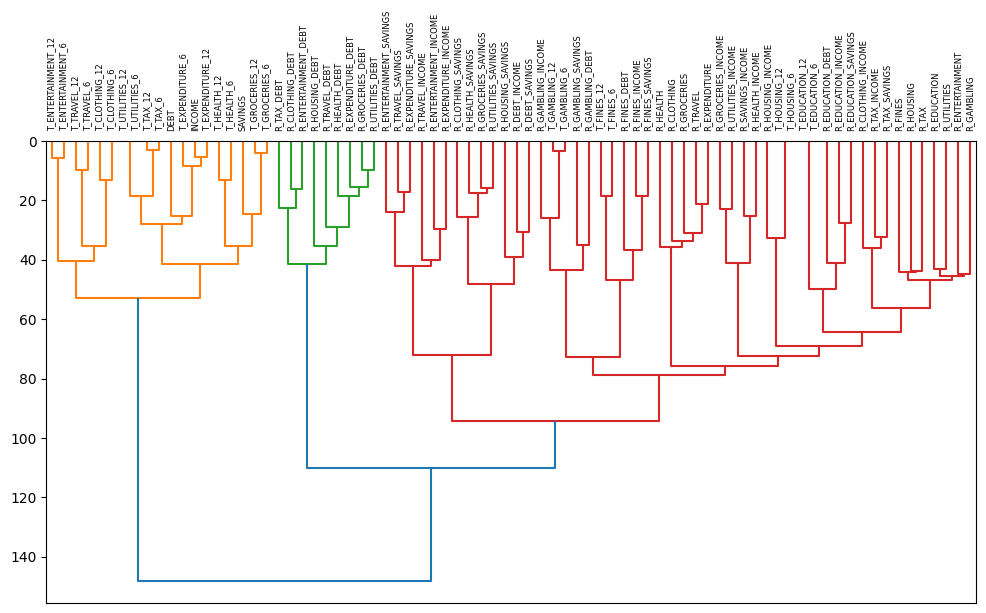

In [74]:
plt.figure(figsize=(12, 6))

dendrogram(
    linked,
    orientation='bottom',
    labels=df_feat_transpose.index,
    distance_sort='ascending',
    show_leaf_counts=True
)

plt.show()

**Definimos los clusters**

In [192]:
# Definimos la cantidad de nuestros clusters
num_clusters = 10

# Asignamos las etiquetas a cada feature
labels = fcluster(linked, t=num_clusters, criterion='maxclust')

In [193]:
# Calculamos la correlación entre nuestros features y la variable objetivo
correlations = []

for col in df_features.columns:
    corr = round(credit_score['CREDIT_SCORE'].corr(credit_score[col]), 3)
    correlations.append(corr)

In [194]:
# Construimos nuestro df de resumen
df_clusters = pd.DataFrame(
    list(zip(df_features.columns, labels, correlations)),
    columns=['Feature', 'Cluster', 'Correlation']
)

df_clusters['Correlation_Abs'] = df_clusters['Correlation'].abs()

df_clusters.sort_values(by=['Cluster', 'Correlation_Abs'], ascending=[True, False], inplace=True)
df_clusters.reset_index(drop=True, inplace=True)

<Axes: >

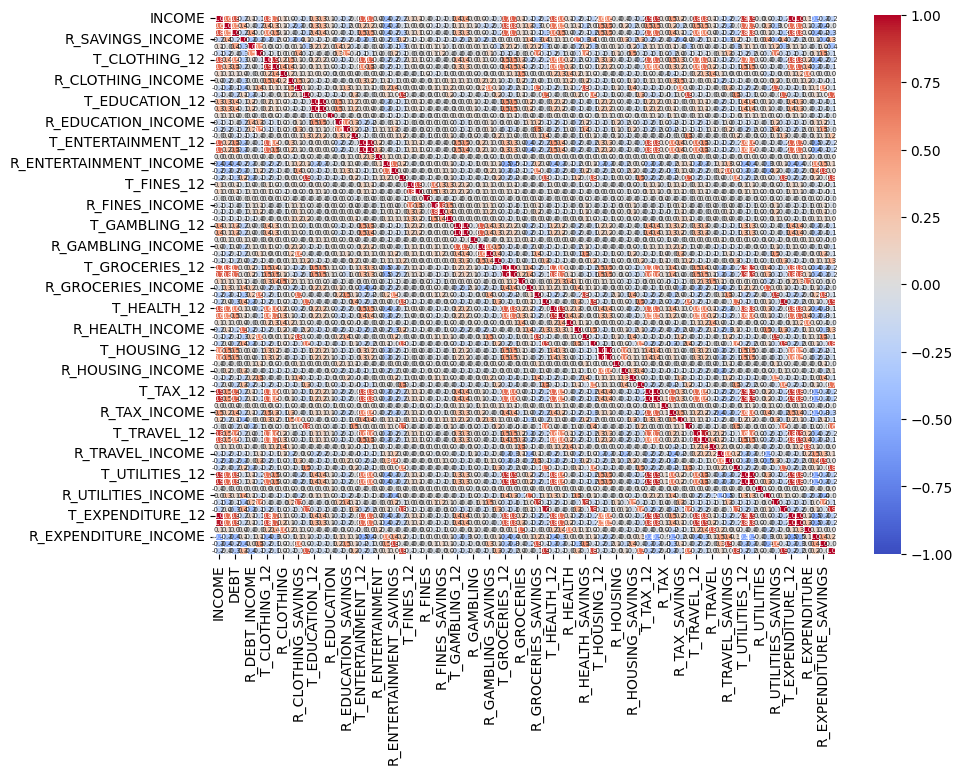

In [195]:
plt.figure(figsize=(10,7))

sns.heatmap(
        df_features.corr(),
        annot=True,
        cmap='coolwarm',
        linewidths=0.5,
        fmt='.1f',
        annot_kws={'size':5},
        vmin=-1,
        vmax=1
    )


<Axes: >

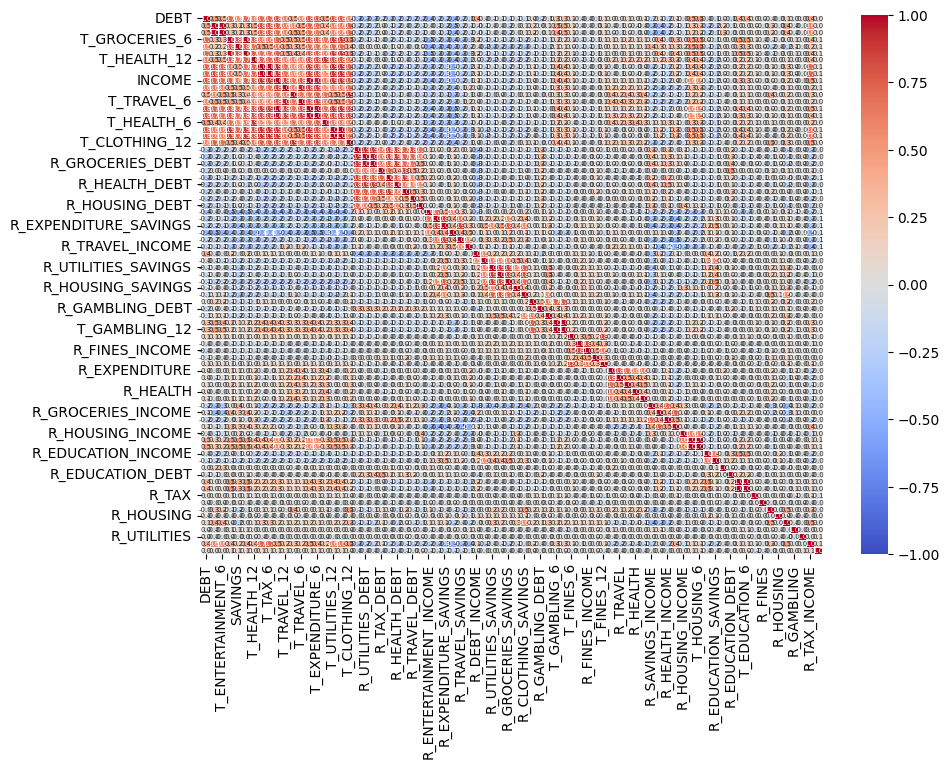

In [196]:
plt.figure(figsize=(10,7))

sns.heatmap(
        df_features[list(df_clusters['Feature'])].corr(),
        annot=True,
        cmap='coolwarm',
        linewidths=0.5,
        fmt='.1f',
        annot_kws={'size':5},
        vmin=-1,
        vmax=1
    )
